In [78]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio import windows
from shapely.geometry import box
from skimage.exposure import rescale_intensity

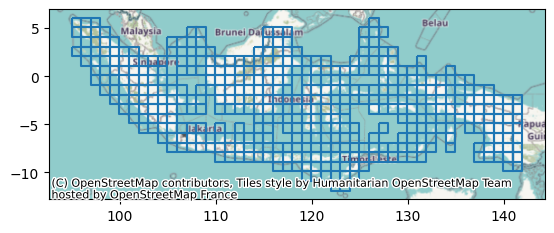

In [69]:
# ROI
# Region of interest
grids = gpd.read_file(
    "https://storage.googleapis.com/gee-ramiqcom-bucket/eo-indonesia/grids.geojson",
)
ax = grids.boundary.plot()
cx.add_basemap(ax, crs="EPSG:4326")

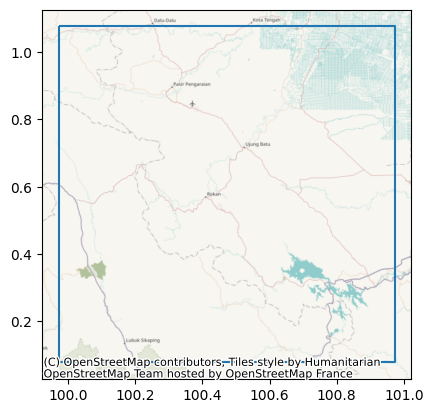

In [70]:
# Select grid no 25
grid_id = 31
roi = grids.iloc[grid_id : grid_id + 1]
ax = roi.boundary.plot()
bbox = roi.union_all().bounds
cx.add_basemap(ax, crs="EPSG:4326")

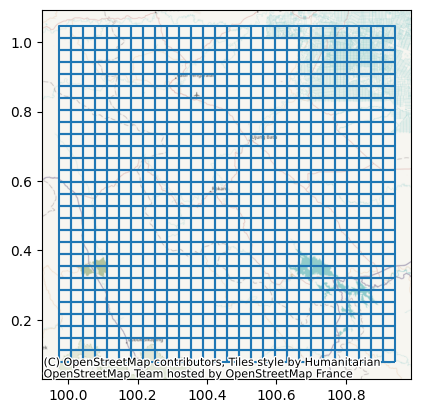

In [73]:
# Create mini grids from grid
distance = (bbox[2] - bbox[0]) / 0.034594
patches = []
for x in range(int(distance)):
    for y in range(int(distance)):
        minx = bbox[0] + (x * 0.034594)
        maxx = minx + 0.034594
        miny = bbox[1] + (y * 0.034594)
        maxy = miny + 0.034594
        polygon = box(minx, miny, maxx, maxy)
        patches.append(polygon)

patches = gpd.GeoDataFrame([], geometry=patches, crs="EPSG:4326")
ax = patches.boundary.plot()
cx.add_basemap(ax, crs="EPSG:4326")

In [2]:
# Data location
modis = "temp/MODIS_Grid-31_2024-06_2024-07.tif"
landsat = "temp/Landsat_Grid-31_2024-06_2024-07.tif"

In [3]:
# Load image
modis_source = rio.open(modis)
landsat_source = rio.open(landsat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1017143..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054666664..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09688888..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping inpu

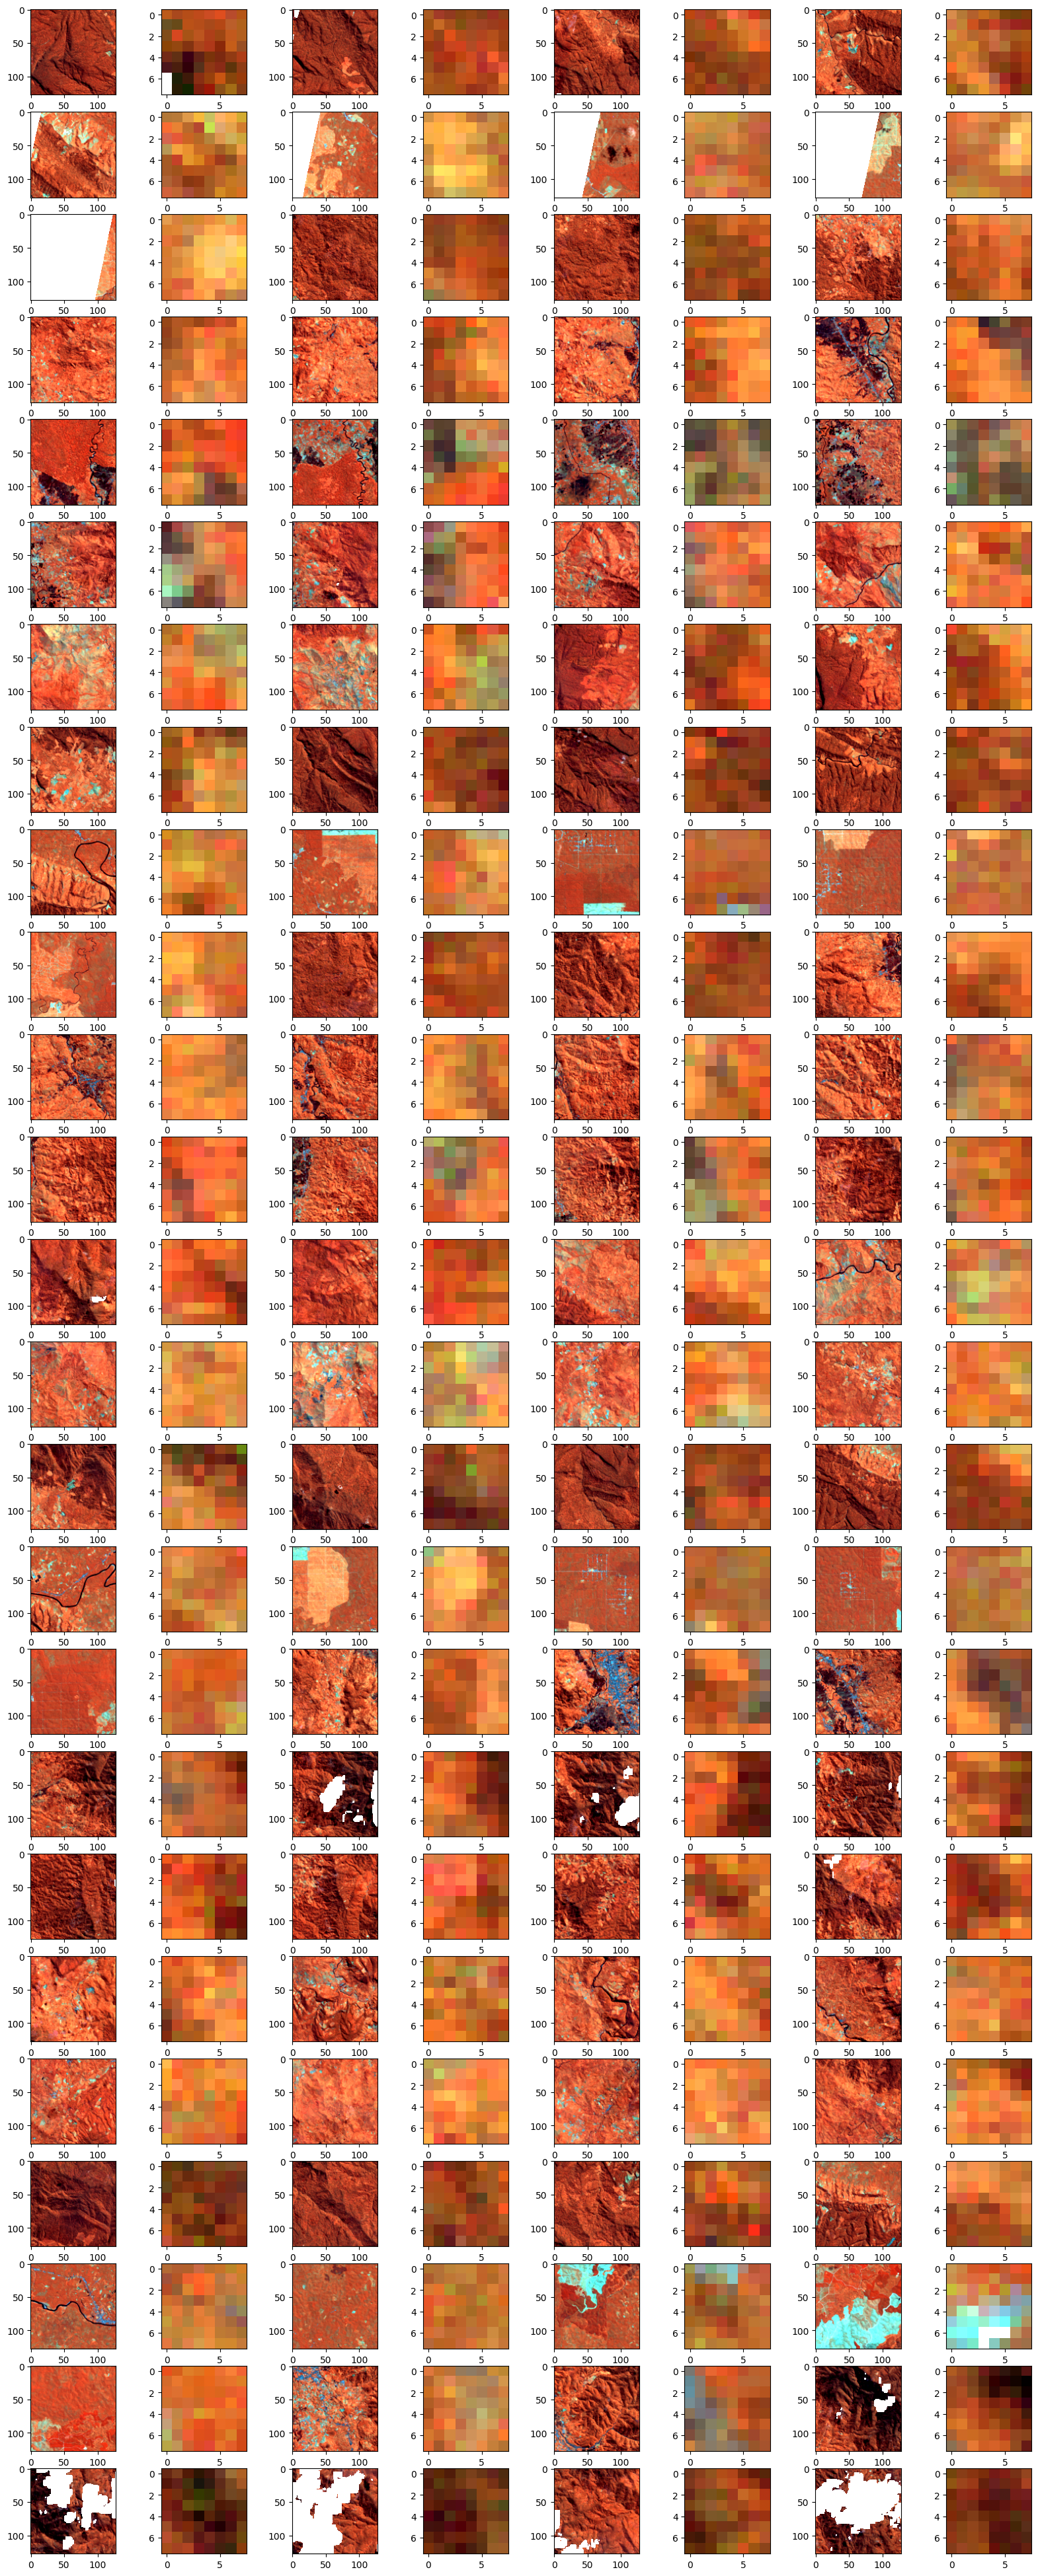

In [99]:
plt.figure(figsize=(20, 50))

# Read image per mini grid
for x in range(100):
    patch = patches.to_crs(landsat_source.crs).iloc[x + 75]["geometry"]
    bbox_patch = patch.bounds
    window_landsat = windows.from_bounds(
        *bbox_patch,
        transform=landsat_source.transform,
    )
    landsat_image = landsat_source.read(
        boundless=True,
        out_dtype="float32",
        out_shape=(128, 128),
        window=window_landsat,
    )
    landsat_image[landsat_image == landsat_source.nodata] = np.nan
    landsat_image = landsat_image / 1e4

    out_range = (0, 1)

    composite_landsat = np.dstack(
        [
            rescale_intensity(
                landsat_image[3],
                in_range=(0.1, 0.4),
                out_range=out_range,
            ),
            rescale_intensity(
                landsat_image[4],
                in_range=(0.075, 0.3),
                out_range=out_range,
            ),
            rescale_intensity(
                landsat_image[5],
                in_range=(0.025, 0.2),
                out_range=out_range,
            ),
        ],
    )

    plt.subplot(25, 8, x * 2 + 1)
    plt.imshow(composite_landsat)

    window_modis = windows.from_bounds(
        *bbox_patch,
        transform=modis_source.transform,
    )
    modis_image = modis_source.read(
        boundless=True,
        out_dtype="float32",
        out_shape=(8, 8),
        window=window_modis,
    )
    modis_image[modis_image == modis_source.nodata] = np.nan
    modis_image = modis_image / 1e4

    composite_modis = np.dstack(
        [
            rescale_intensity(
                modis_image[3],
                in_range=(0.1, 0.4),
                out_range=out_range,
            ),
            rescale_intensity(
                modis_image[4],
                in_range=(0.075, 0.3),
                out_range=out_range,
            ),
            rescale_intensity(
                modis_image[5],
                in_range=(0.025, 0.2),
                out_range=out_range,
            ),
        ],
    )
    plt.subplot(25, 8, x * 2 + 2)
    plt.imshow(composite_modis)